In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
from math import *
from tqdm.notebook import  tqdm
import matplotlib.image as mpimg

import statsmodels.api as sms
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data exploration and cleaning

In [3]:
shot_logs = pd.read_csv('../raw_data/shot_logs.csv')
shot_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

In [4]:
display(shot_logs.FGM.groupby(shot_logs.LOCATION).value_counts(normalize=True)*100)
display(shot_logs.FGM.groupby(shot_logs.PERIOD).value_counts(normalize=True)*100)

LOCATION  FGM
A         0      55.188275
          1      44.811725
H         0      54.382645
          1      45.617355
Name: FGM, dtype: float64

PERIOD  FGM
1       0      53.947175
        1      46.052825
2       0      54.889261
        1      45.110739
3       0      54.285803
        1      45.714197
4       0      55.990111
        1      44.009889
5       0      60.964912
        1      39.035088
6       0      56.547619
        1      43.452381
7       0      62.790698
        1      37.209302
Name: FGM, dtype: float64

<AxesSubplot:>

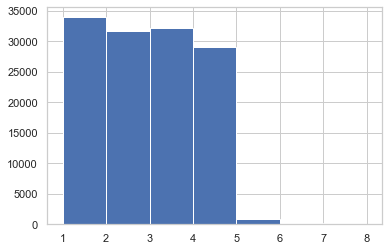

In [5]:
shot_logs.PERIOD.hist(bins=[1, 2, 3, 4, 5, 6, 7, 8])

We drop the location variable that has not a major effect on the shooting success.

We drop the period variable that has not a major effect on the shooting success in the first periods, and we can also drop first data where period is above 4, that represent a small amount of data. As we have a sufficient amount of data, we focus our analysis on a regular play time.

We also drop all rows containing NaN values.

In [6]:
shot_logs = shot_logs[shot_logs.PERIOD.isin([1, 2, 3, 4])]
columns_to_drop = ['GAME_ID', 'MATCHUP', 'FINAL_MARGIN', 'SHOT_NUMBER', 'W', 'SHOT_CLOCK', 'DRIBBLES', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'PTS', 'player_name', 'player_id', 'LOCATION']
shot_logs.drop(columns = columns_to_drop, inplace = True)
shot_logs.dropna(axis=0, inplace=True)

<AxesSubplot:xlabel='GAME_CLOCK'>

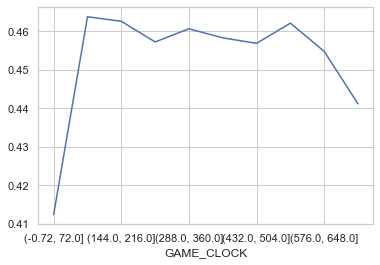

In [7]:
shot_logs.GAME_CLOCK = shot_logs.GAME_CLOCK.apply(lambda x: float(x.split(':')[0])*60 + float(x.split(':')[1]))
shot_logs.groupby(pd.cut(shot_logs.GAME_CLOCK, bins = 10)).FGM.aggregate('mean').plot()

Shot clock has a minor effect on the shooting success probability, and we thus drop it.

In [8]:
display(shot_logs.TOUCH_TIME.describe())
shot_logs = shot_logs[shot_logs.TOUCH_TIME >= 0]

count    126946.000000
mean          2.757781
std           3.030862
min        -163.600000
25%           0.900000
50%           1.600000
75%           3.700000
max          24.900000
Name: TOUCH_TIME, dtype: float64

<AxesSubplot:ylabel='Frequency'>

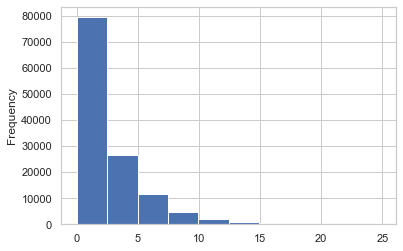

In [9]:
shot_logs.TOUCH_TIME.plot(kind = 'hist')

<AxesSubplot:xlabel='TOUCH_TIME'>

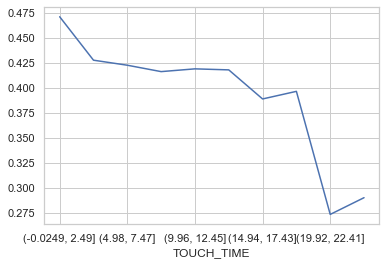

In [10]:
shot_logs.groupby(pd.cut(shot_logs.TOUCH_TIME, bins = 10)).FGM.aggregate('mean').plot()

Shooting success probability seem to vary more accoring to touch time, but we leave it outside the scope of our analysis for now.

In [11]:
shot_logs.drop(columns = ['PERIOD', 'GAME_CLOCK', 'TOUCH_TIME'], inplace = True)

In [12]:
shot_logs.rename(columns = {'SHOT_DIST': 'dist_basket', 'CLOSE_DEF_DIST': 'dist_def'}, inplace = True)

# Feature Engineering

In [13]:
#What is the proportion of points where the distance to the basket and to the other defender are exactly 0?
print((len(shot_logs[shot_logs.dist_basket == 0])/len(shot_logs)))
print((len(shot_logs[shot_logs.dist_def == 0])/len(shot_logs)))
#We delete these points in order to create a log of distance variable

shot_logs = shot_logs[shot_logs.dist_def != 0][shot_logs.dist_basket != 0]

3.1586345222960115e-05
0.00816507024013519


/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [14]:
# calculate four new variables
shot_logs['dist_basket^2/100'] = shot_logs['dist_basket'].apply(lambda x: x**2/100)
shot_logs['dist_def^2/100'] = shot_logs['dist_def'].apply(lambda x: x**2/100)
shot_logs['log_dist_basket'] = shot_logs['dist_basket'].apply(lambda x: log(x))
shot_logs['log_dist_def'] = shot_logs['dist_def'].apply(lambda x: log(x))

In [15]:
#reorder dataframe
FGM_column = shot_logs.pop('FGM')
shot_logs.insert(value = FGM_column, loc = 6, column = 'made')

# Features selection and model construction

In [16]:
features = ['dist_basket', 'dist_def', 'dist_basket^2/100', 'dist_def^2/100', 'log_dist_basket', 'log_dist_def']
dependent = ['made']

X = shot_logs[features]
y = shot_logs[dependent]

mod = sms.Logit(y, X)
res = mod.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.660625
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   made   No. Observations:               125599
Model:                          Logit   Df Residuals:                   125593
Method:                           MLE   Df Model:                            5
Date:                Fri, 24 Dec 2021   Pseudo R-squ.:                 0.04083
Time:                        05:39:03   Log-Likelihood:                -82974.
converged:                       True   LL-Null:                       -86505.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
dist_basket          -0.0796      0.007    -11.294      0.000      -0.093      -0.066
dist_def

As the variables are correlated here, we do not rely on this logistic regression to perform features selection.

# First model

In [17]:
features = ['dist_basket', 'dist_def', 'dist_basket^2/100', 'dist_def^2/100', 'log_dist_basket', 'log_dist_def']
dependent = ['made']

X = shot_logs[features]
y = shot_logs[dependent]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

mod = sms.Logit(y_train, X_train)
res = mod.fit()

y_pred = res.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))

label_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print('Accuracy: ', 1 - np.average(abs(y_test.made-label_pred)))

Optimization terminated successfully.
         Current function value: 0.661088
         Iterations 5
MSE:  0.23361996511961514
Accuracy:  0.6107652962748504


The error with the basic model is 0.23.

Let's try to improve on this error with further features selection.

To perform further feature selection, we combine the use of a gradient boosting algorithm, that provides features importance, and the use of a lasso regularized logistic regression.

## Gradient Boosting

In [18]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))

/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE:  0.3834684423856398


<BarContainer object of 6 artists>

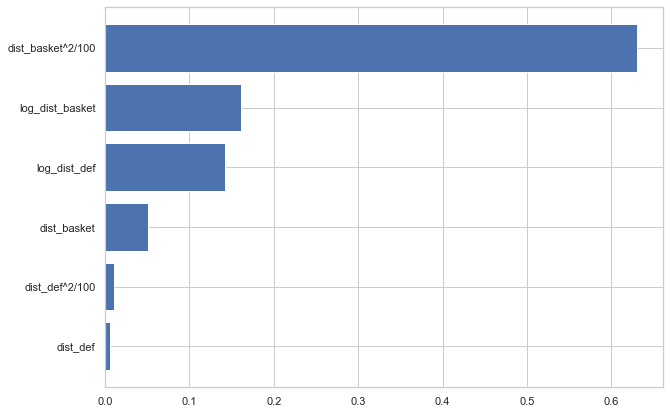

In [19]:
zipped = zip(X.columns, clf.feature_importances_)
sorted_zip = sorted(zipped, key = lambda x: x[1])

fig, ax = plt.subplots(figsize = (10, 7))
ax.barh([x[0] for x in sorted_zip], [x[1] for x in sorted_zip])

According to the gradient boosting model, if we were to keep only one distance to basket and one distance to defender feature it would be `log_dist_basket` and `dist_def`.

## Lasso Regularized Logistic Regression

In [20]:
lambdas = np.arange(100, 1000, 100)

coefs = []
for lambd in tqdm(lambdas):
    clf = LogisticRegression(penalty='l1', C = 1/lambd, solver = 'liblinear').fit(X, y)
    coefs.append(clf.coef_)

/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

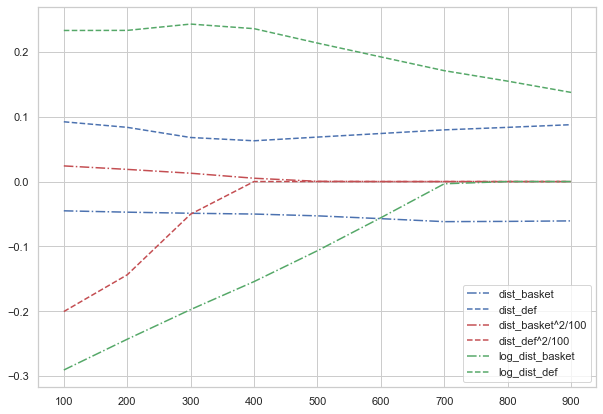

In [21]:
coef_0 = [x[0][0] for x in coefs]
coef_1 = [x[0][1] for x in coefs]
coef_2 = [x[0][2] for x in coefs]
coef_3 = [x[0][3] for x in coefs]
coef_4 = [x[0][4] for x in coefs]
coef_5 = [x[0][5] for x in coefs]

coef_lines = [coef_0, coef_1, coef_2, coef_3, coef_4, coef_5]

linestyles = ['-.', '--']*3
colors = ['b', 'b', 'r', 'r', 'g', 'g']

fig, ax = plt.subplots(figsize = (10, 7))
for i in range(6):
    ax.plot(lambdas, coef_lines[i], label = X.columns[i], linestyle = linestyles[i], c = colors[i])

plt.legend()

The first three variables that are set to 0 by the regularization are: `dist_basket^2/100`, `dist_def^2/100` and then `log_dist_basket`.

# Second model (based on Gradient Boosting features importance)

In [22]:
features = ['dist_def', 'log_dist_basket']
dependent = ['made']

X = shot_logs[features]
y = shot_logs[dependent]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

mod = sms.Logit(y_train, X_train)
res = mod.fit()

y_pred = res.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))

label_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print('Accuracy: ', 1 - np.average(y_test.made - label_pred))

Optimization terminated successfully.
         Current function value: 0.671316
         Iterations 5
MSE:  0.23792866700207632
Accuracy:  0.703797529434472


# Third model (based on regularized logistic regression)

In [23]:
features = ['dist_def', 'dist_basket', 'log_dist_basket']
dependent = ['made']

X = shot_logs[features]
y = shot_logs[dependent]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

mod = sms.Logit(y_train, X_train)
res = mod.fit()

y_pred = res.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))

label_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print('Accuracy: ', 1 - np.average(y_test.made - label_pred))

Optimization terminated successfully.
         Current function value: 0.664378
         Iterations 5
MSE:  0.23486827005543548
Accuracy:  0.8707778421154218


# Forward Feature Selection

In [24]:
features = ['dist_basket', 'dist_def', 'dist_basket^2/100', 'dist_def^2/100', 'log_dist_basket', 'log_dist_def']
dependent = ['made']

X = shot_logs[features]
y = shot_logs[dependent]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

d = {'k': [], 'MSE' : [], 'accuracy' : [], 'features' : []}

used_features = []

for k in tqdm(range(1, 7)):

    d['k'].append(k)

    non_used_features = [feature for feature in features if feature not in used_features]
    mses = []
    for x in non_used_features:
        X_train_adapted = X_train[used_features + [x]]
        X_test_adapted = X_test[used_features + [x]]
        clf = sms.Logit(y_train, X_train_adapted)
        res = clf.fit()
        y_pred = res.predict(X_test_adapted)
        mses.append(mean_squared_error(y_test, y_pred))

    best_mse = min(mses)
    best_feature = non_used_features[np.argmin(mses)]
    used_features.append(best_feature)

    X_train_sfs = X_train[used_features]
    X_test_sfs = X_test[used_features]

    clf = sms.Logit(y_train, X_train_sfs)
    res = clf.fit()

    y_pred = res.predict(X_test_sfs)
    d['MSE'].append(mean_squared_error(y_test, y_pred))

    label_pred = [1 if x >= 0.5 else 0 for x in y_pred]
    d['accuracy'].append(1 - np.average(abs(y_test.made-label_pred)))

    d['features'].append(used_features.copy())

results = pd.DataFrame(d)


Optimization terminated successfully.
         Current function value: 0.676616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671530
  

In [25]:
results.features[4]

['dist_basket^2/100',
 'dist_def',
 'dist_basket',
 'dist_def^2/100',
 'log_dist_basket']

In [26]:
results

,k,MSE,accuracy,features
0,1,0.240494,0.551317,[dist_basket^2/100]
1,2,0.236774,0.587893,"[dist_basket^2/100, dist_def]"
2,3,0.234862,0.612092,"[dist_basket^2/100, dist_def, dist_basket]"
3,4,0.233538,0.610910,"[dist_basket^2/100, dist_def, dist_basket, dis..."
4,5,0.233515,0.611344,"[dist_basket^2/100, dist_def, dist_basket, dis..."
5,6,0.233620,0.610765,"[dist_basket^2/100, dist_def, dist_basket, dis..."


# Conclusion

> For our shooting success probability task we want to minimize the MSE.
> Overall, the best models regarding this capability is the model given by the forward feature selection, with k = 4 and k = 5 features. Both give almost the exact same MSE.
> We choose the model with k = 5 features to compute the shooting success probability in the game data. The retained features are `dist_basket^2/100`, `dist_def` `dist_basket`, `dist_def^2/100`, `log_dist_basket`.

In [27]:
features = ['dist_basket^2/100', 'dist_def', 'dist_basket', 'dist_def^2/100', 'log_dist_basket']
dependent = ['made']

X = shot_logs[features]
y = shot_logs[dependent]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

mod = sms.Logit(y_train, X_train)
res = mod.fit()

y_pred = res.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))

label_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print('Accuracy: ', 1 - np.average(abs(y_test.made-label_pred)))

res.save('../model/logit.pkl')

Optimization terminated successfully.
         Current function value: 0.661394
         Iterations 5
MSE:  0.23351481125195153
Accuracy:  0.6113443350704497


# Heatmaps of success probability on the field

In [28]:
res = sms.load('../model/logit.pkl')

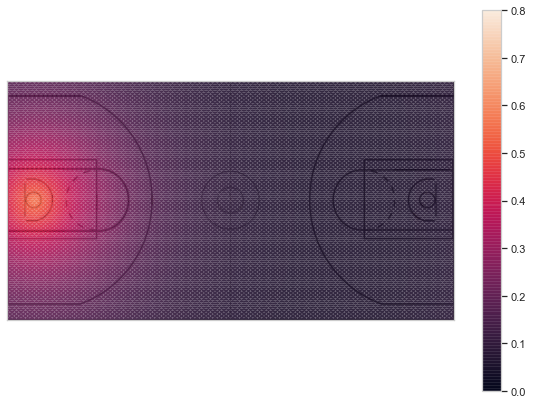

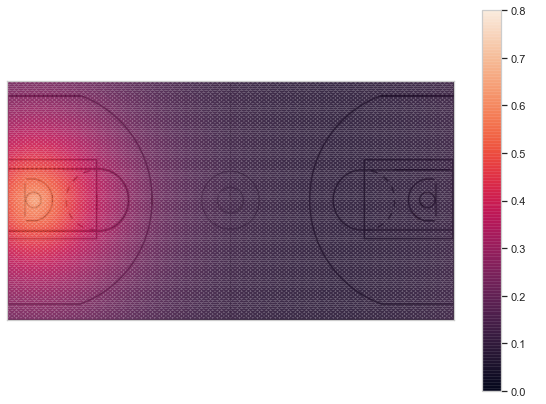

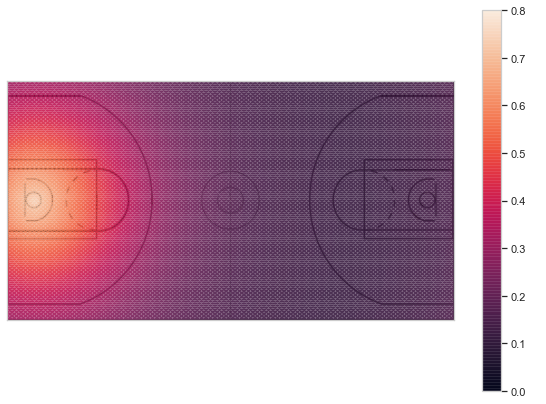

In [32]:
def distance_from_basket(x, y):
    basket_left = [6.0,25.0]
    distance_left = [x-basket_left[0],y-basket_left[1]]
    distance_left[0], distance_left[1] = distance_left[0]*distance_left[0], distance_left[1]*distance_left[1]
    return sqrt(sum(distance_left))

savefigs = True

for distance_to_def in [1, 2.5, 5]:
    x = np.repeat(np.arange(0, 100, 0.1), 500) # [0, 0, ... 0, 1, ...]
    y = np.tile(np.arange(0, 50, 0.1), 1000) # [0, 1, 49, 0, 1, ...]

    heatmap_df = pd.DataFrame({'x': x, 'y': y})
    heatmap_df = heatmap_df[(heatmap_df.x != 6) | (heatmap_df.y != 25)] # exclude the basket point to avoid problems with the log

    heatmap_df['dist_from_basket'] = heatmap_df.apply(lambda r: distance_from_basket(r['x'], r['y']), axis = 1)
    heatmap_df['dist_to_closest_def'] = distance_to_def
    heatmap_df["dist_from_basket^2/100"] = heatmap_df["dist_from_basket"].apply(lambda x: x**2/100)
    heatmap_df["log_dist_from_basket"] = heatmap_df["dist_from_basket"].apply(lambda x: log(x))
    heatmap_df["dist_to_closest_def^2/100"] = heatmap_df["dist_to_closest_def"].apply(lambda x: x**2/100)
    heatmap_df["log_dist_to_closest_def"] = heatmap_df["dist_to_closest_def"].apply(lambda x: log(x))

    res = sms.load('../model/logit.pkl')
    model_features = features = ['dist_from_basket^2/100', 'dist_to_closest_def', 'dist_from_basket', 'dist_to_closest_def^2/100', 'log_dist_from_basket']
    X = heatmap_df[model_features]

    heatmap_df['shoot_prob'] = res.predict(X)

    x = heatmap_df['x']
    y = heatmap_df['y']
    z = heatmap_df['shoot_prob']

    image = mpimg.imread("../raw_data/court.png")
    size = np.shape(image)
    reshape_size = [size[0]/50, size[1]/100]

    ax, fig = plt.subplots(figsize = (10, 7))
    plt.hexbin(x*reshape_size[1], y*reshape_size[0], C=z, alpha = 0.9, edgecolors = 'none', vmin = 0, vmax = 0.8)
    cb = plt.colorbar()
    cb.set_label('success_probability', color = 'white')
    title = f'shooting_success_probability_with_dist_def_{distance_to_def}'
    plt.title(title, color = 'white')
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    if savefigs:
        plt.savefig('../results/' + title + '.png')
